In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import requests as re
from tqdm import tqdm
import time

import nba_api
from nba_api.live.nba.endpoints import scoreboard
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguedashplayerstats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from mar_designs import tidy_axes

In [2]:
# Variables for the notebook
facecolor = "#F7F5F2"
figsize=(11,6)
subplotFigsize=(28,6)
titlesize=16
labelsize=14

pd.set_option('display.max_columns', None)

## Apply PCA to leaguedashplayerstats endpoint
### This contains total stats of every player that played in the 2023-2024 season

In [3]:
# Get player stats for the previous season
df = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24').get_data_frames()[0]

# All quantitative stats
features = [
     'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
    'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']

X = df[features].dropna()

# Add a pseudolabel for starters
df['STARTER'] = df["MIN"]/df["GP"] >= 25

In [4]:
# Head of dataframe
df.head(2)

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,STARTER
0,1630639,A.J. Lawson,A.J.,1610612742,DAL,23.0,42,27,15,0.643,310.900000,54,121,0.446,13,50,0.260,15,23,0.652,14,36,50,20,14,10,3,8,22,13,136,18,251.0,0,0,245.0,341,231,168,105,410,378,373,303,346,338,428,382,374,445,389,407,408,414,394,386,428,211,148,415,385,192,400,257,38,405,False
1,1631260,AJ Green,AJ,1610612749,MIL,24.0,56,35,21,0.625,614.281667,83,196,0.423,69,169,0.408,17,19,0.895,9,55,64,30,12,9,4,3,49,20,252,50,400.8,0,0,441.0,252,155,253,128,333,327,320,393,191,205,72,372,388,54,424,366,381,373,409,398,410,121,223,375,313,145,369,257,38,343,False


In [16]:
# Save the cleaned dataset used for PCA
df_cleaned = pd.DataFrame(X, columns=features)
df_cleaned.to_csv("../data/module2_data/pca_cleaned.csv")
df_cleaned.head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,54,121,0.446,13,50,0.260,15,23,0.652,14,36,50,20,14,10,3,8,22,13,136,18
1,83,196,0.423,69,169,0.408,17,19,0.895,9,55,64,30,12,9,4,3,49,20,252,50
2,18,62,0.290,10,39,0.256,2,2,1.000,2,16,18,5,8,1,2,3,6,1,48,-51
3,398,716,0.556,40,138,0.290,177,269,0.658,174,297,471,259,105,56,45,57,142,223,1013,423
4,186,417,0.446,84,217,0.387,58,63,0.921,23,100,123,140,53,42,6,20,125,65,514,85


In [5]:
# PCA object on scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

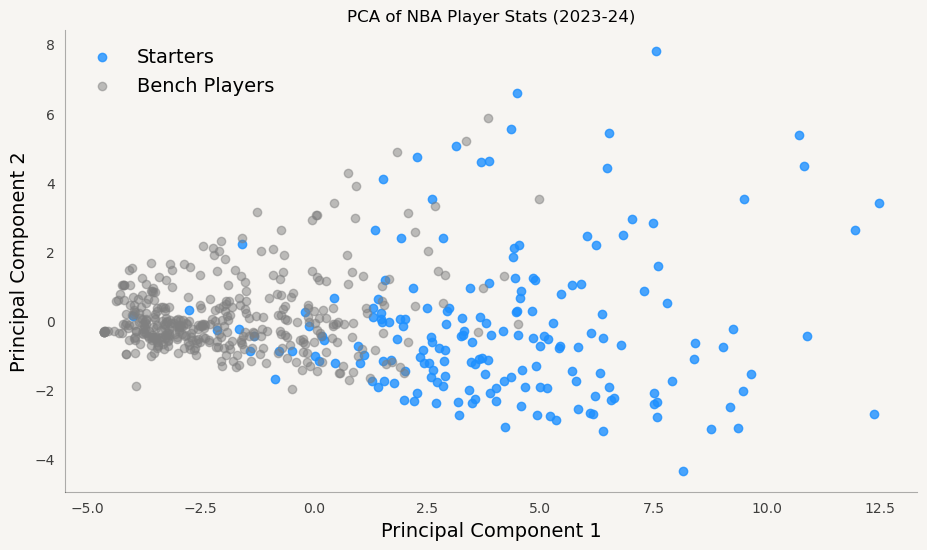

[0.62807593 0.10534739]
0.7334233189081657


In [6]:
# Create a mask based on STARTER feature
starter_mask = df['STARTER'].values
nonstarter_mask = ~starter_mask

# Plot PCA with different colors
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

ax.scatter(X_pca_2[starter_mask, 0], X_pca_2[starter_mask, 1], alpha=0.8, label='Starters', color='dodgerblue')
ax.scatter(X_pca_2[nonstarter_mask, 0], X_pca_2[nonstarter_mask, 1], alpha=0.5, label='Bench Players', color='gray')

ax.set_title('PCA of NBA Player Stats (2023-24)')
ax.set_xlabel('Principal Component 1', fontsize=labelsize)
ax.set_ylabel('Principal Component 2', fontsize=labelsize)
tidy_axes(ax)
ax.legend(loc=2, frameon=False, fontsize=labelsize)
plt.show()

print(pca_2.explained_variance_ratio_)
print(pca_2.explained_variance_ratio_.sum())

[0.62807593 0.10534739 0.05871266]
0.792135977019398


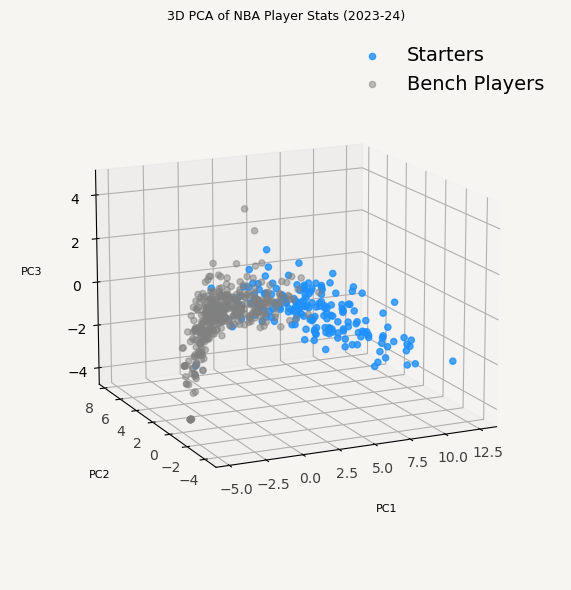

In [7]:
# Run PCA with 3 components
pca_3 = PCA(n_components=3)
X_pca_3d = pca_3.fit_transform(X_scaled)


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)


ax.scatter(
    X_pca_3d[starter_mask, 0], X_pca_3d[starter_mask, 1], X_pca_3d[starter_mask, 2],
    color='dodgerblue', label='Starters', alpha=0.8
)
ax.scatter(
    X_pca_3d[nonstarter_mask, 0], X_pca_3d[nonstarter_mask, 1], X_pca_3d[nonstarter_mask, 2],
    color='gray', label='Bench Players', alpha=0.5
)

ax.set_title('3D PCA of NBA Player Stats (2023-24)', fontsize=titlesize-7)
ax.set_xlabel('PC1', fontsize=labelsize-6, labelpad=20)
ax.set_ylabel('PC2', fontsize=labelsize-6, labelpad=20)
ax.set_zlabel('PC3', fontsize=labelsize-6, labelpad=15)
ax.view_init(elev=15, azim=65+180)
ax.legend(fontsize=labelsize-16)
plt.tight_layout()
tidy_axes(ax)



print(pca_3.explained_variance_ratio_)
print(pca_3.explained_variance_ratio_.sum())
ax.set_box_aspect(None, zoom=0.85)
plt.savefig("../images/module2_images/pca3.png", bbox_inches="tight")
plt.show()

In [8]:
# Top 3 eigenvalues
eigenvalues = pca_3.explained_variance_

print("Top 3 Eigenvalues:")
print(eigenvalues[:3])

Top 3 Eigenvalues:
[13.21269357  2.21616966  1.23512513]


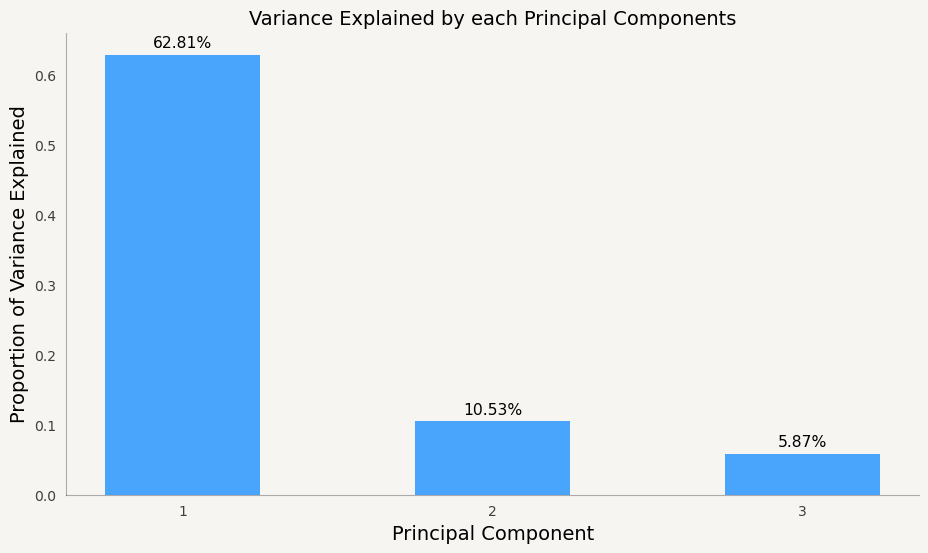

In [9]:
# Scree plot using pca_3
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

explained = pca_3.explained_variance_ratio_
components = np.arange(1, len(explained) + 1)
ax.bar(components, explained, color='dodgerblue', alpha=0.8, width=0.5)

ax.set_title('Variance Explained by each Principal Components', fontsize=labelsize)
ax.set_xlabel('Principal Component', fontsize=labelsize)
ax.set_ylabel('Proportion of Variance Explained', fontsize=labelsize)
tidy_axes(ax)


ax.set_xticks([1,2,3])
ax.set_xticklabels(["1", "2", "3"])


# add % labels on top of each bar
for i, v in enumerate(explained):
    ax.text(components[i], v + 0.01, f"{v:.2%}", ha='center', fontsize=labelsize * 0.8)

plt.savefig("../images/module2_images/screeplot.png")
plt.show()

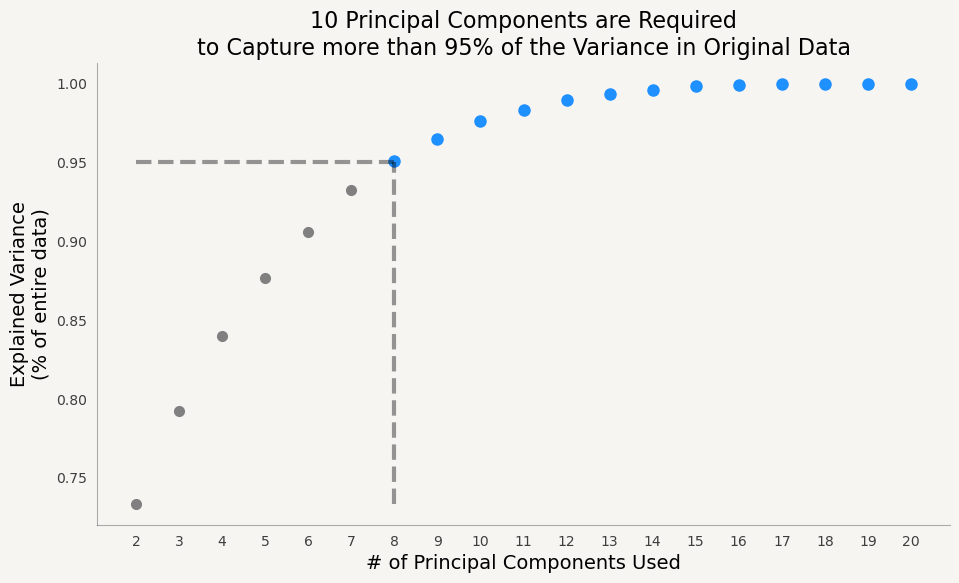

In [10]:
explainedVariances = []
n_comps = []
for n in range(2,len(features)):
    pca_n = PCA(n_components=n)
    X_pca = pca_n.fit_transform(X_scaled)
    
    
    n_comps.append(n)
    explainedVariances.append(pca_n.explained_variance_ratio_.sum())

# Convert lists to numpy array for masking
n_comps = np.array(n_comps)
explainedVariances = np.array(explainedVariances)
    
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

variancesAbove95 = explainedVariances > 0.95
xloc = np.min(n_comps[variancesAbove95])

ax.plot(n_comps[variancesAbove95], explainedVariances[variancesAbove95], 'o', markersize=8, color="dodgerblue")

ax.vlines(xloc, np.min(explainedVariances), 0.95, color="black", linestyle="dashed", alpha=0.4, linewidth=3)
ax.hlines(0.95, np.min(n_comps), xloc, color="black", linestyle="dashed", alpha=0.4, linewidth=3)

ax.plot(n_comps[~variancesAbove95], explainedVariances[~variancesAbove95], 'o', color="grey", markersize=7)

ax.set_xticks(n_comps)
ax.set_xticklabels(n_comps)

tidy_axes(ax)

ax.set_title("10 Principal Components are Required\nto Capture more than 95% of the Variance in Original Data", fontsize=titlesize)
# plt.tight_layout()
ax.set_xlabel("# of Principal Components Used", fontsize=labelsize)
ax.set_ylabel("Explained Variance\n(% of entire data)", fontsize=labelsize)
plt.savefig("../images/module2_images/variance95.png")
plt.show()

In [11]:
pd.DataFrame(X, columns=features).head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,54,121,0.446,13,50,0.260,15,23,0.652,14,36,50,20,14,10,3,8,22,13,136,18
1,83,196,0.423,69,169,0.408,17,19,0.895,9,55,64,30,12,9,4,3,49,20,252,50
2,18,62,0.290,10,39,0.256,2,2,1.000,2,16,18,5,8,1,2,3,6,1,48,-51
3,398,716,0.556,40,138,0.290,177,269,0.658,174,297,471,259,105,56,45,57,142,223,1013,423
4,186,417,0.446,84,217,0.387,58,63,0.921,23,100,123,140,53,42,6,20,125,65,514,85


## Now normalize by MIN and reevaluate PCA

In [12]:
# Normalize by MIN column in original df
X_df = pd.DataFrame(X, columns=features)

exclude = ['FG_PCT', 'FG3_PCT', 'FT_PCT']
divided = X_df.drop(columns=exclude).div(df['MIN'], axis=0)
result = divided.assign(**df[exclude])
result.head()

,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FG_PCT,FG3_PCT,FT_PCT
0,0.173689,0.389193,0.041814,0.160823,0.048247,0.073979,0.045031,0.115793,0.160823,0.064329,0.045031,0.032165,0.009649,0.025732,0.070762,0.041814,0.437440,0.057896,0.446,0.260,0.652
1,0.135117,0.319072,0.112326,0.275118,0.027675,0.030930,0.014651,0.089535,0.104187,0.048838,0.019535,0.014651,0.006512,0.004884,0.079768,0.032558,0.410235,0.081396,0.423,0.408,0.895
2,0.105430,0.363146,0.058572,0.228431,0.011714,0.011714,0.011714,0.093715,0.105430,0.029286,0.046858,0.005857,0.011714,0.017572,0.035143,0.005857,0.281146,-0.298717,0.290,0.256,1.000
3,0.173284,0.311737,0.017415,0.060083,0.077063,0.117119,0.075757,0.129310,0.205067,0.112765,0.045716,0.024382,0.019592,0.024817,0.061825,0.097091,0.441046,0.184168,0.556,0.290,0.658
4,0.146538,0.328528,0.066178,0.170961,0.045695,0.049634,0.018120,0.078784,0.096904,0.110297,0.041755,0.033089,0.004727,0.015757,0.098480,0.051209,0.404949,0.066966,0.446,0.387,0.921


In [13]:
# PCA object on scaled data by MIN column
scaler = StandardScaler()
X_scaled = scaler.fit_transform(result.values)

# PCA 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

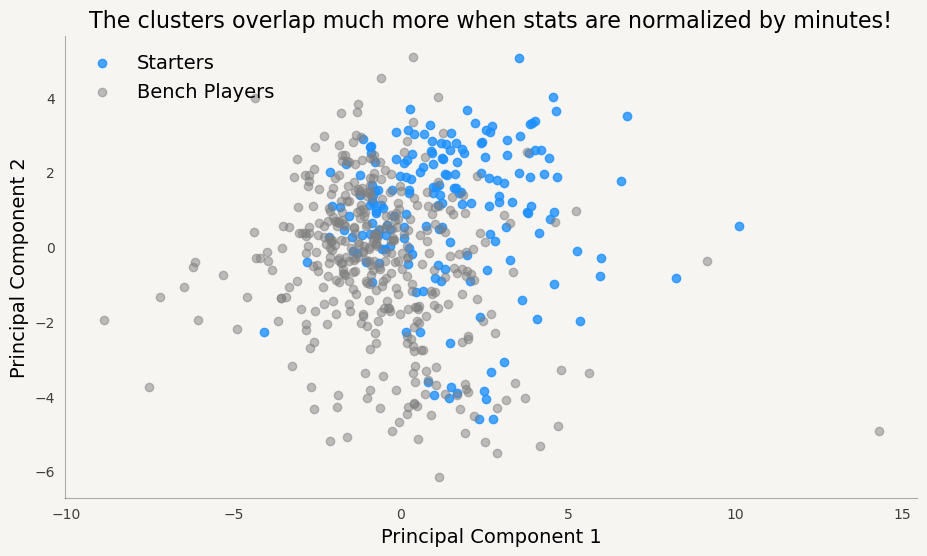

[0.2627565 0.2030152]
0.465771698893525


In [14]:
# Create a mask based on STARTER feature
starter_mask = df['STARTER'].values
nonstarter_mask = ~starter_mask

# Plot PCA with different colors
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

ax.scatter(X_pca_2[starter_mask, 0], X_pca_2[starter_mask, 1], alpha=0.8, label='Starters', color='dodgerblue')
ax.scatter(X_pca_2[nonstarter_mask, 0], X_pca_2[nonstarter_mask, 1], alpha=0.5, label='Bench Players', color='gray')

ax.set_title('The clusters overlap much more when stats are normalized by minutes!', fontsize=titlesize)
ax.set_xlabel('Principal Component 1', fontsize=labelsize)
ax.set_ylabel('Principal Component 2', fontsize=labelsize)
tidy_axes(ax)
ax.legend(loc=2, frameon=False, fontsize=labelsize)
plt.savefig("../images/module2_images/pca_min_scaled.png")
plt.show()

print(pca_2.explained_variance_ratio_)
print(pca_2.explained_variance_ratio_.sum())